In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import folium

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor 

from scipy import stats

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8')

In [38]:
df = pd.read_csv('detailed_ev_charging_stations.csv')

In [40]:
#Basic information
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Station ID                   5000 non-null   object 
 1   Latitude                     5000 non-null   float64
 2   Longitude                    5000 non-null   float64
 3   Address                      5000 non-null   object 
 4   Charger Type                 5000 non-null   object 
 5   Cost (USD/kWh)               5000 non-null   float64
 6   Availability                 5000 non-null   object 
 7   Distance to City (km)        5000 non-null   float64
 8   Usage Stats (avg users/day)  5000 non-null   int64  
 9   Station Operator             5000 non-null   object 
 10  Charging Capacity (kW)       5000 non-null   int64  
 11  Connector Types              5000 non-null   object 
 12  Installation Year            5000 non-null   int64  
 13  Rene

In [42]:
#Basic numerical statistics
print("\nNumerical Statistics:")
print(df.describe())


Numerical Statistics:
          Latitude    Longitude  Cost (USD/kWh)  Distance to City (km)  \
count  5000.000000  5000.000000     5000.000000            5000.000000   
mean     19.942607     8.833487        0.300196              10.201810   
std      32.315818    93.724046        0.115733               5.608316   
min     -89.680850  -178.870028        0.100000               0.500000   
25%      13.758953   -87.680319        0.200000               5.430000   
50%      34.029053    18.495233        0.300000              10.190000   
75%      41.840249   100.454629        0.400000              14.902500   
max      89.464534   179.664661        0.500000              20.000000   

       Usage Stats (avg users/day)  Charging Capacity (kW)  Installation Year  \
count                  5000.000000             5000.000000        5000.000000   
mean                     55.453800              144.272000        2016.569400   
std                      26.494986              128.370674         

In [44]:
#Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Station ID                     0
Latitude                       0
Longitude                      0
Address                        0
Charger Type                   0
Cost (USD/kWh)                 0
Availability                   0
Distance to City (km)          0
Usage Stats (avg users/day)    0
Station Operator               0
Charging Capacity (kW)         0
Connector Types                0
Installation Year              0
Renewable Energy Source        0
Reviews (Rating)               0
Parking Spots                  0
Maintenance Frequency          0
dtype: int64


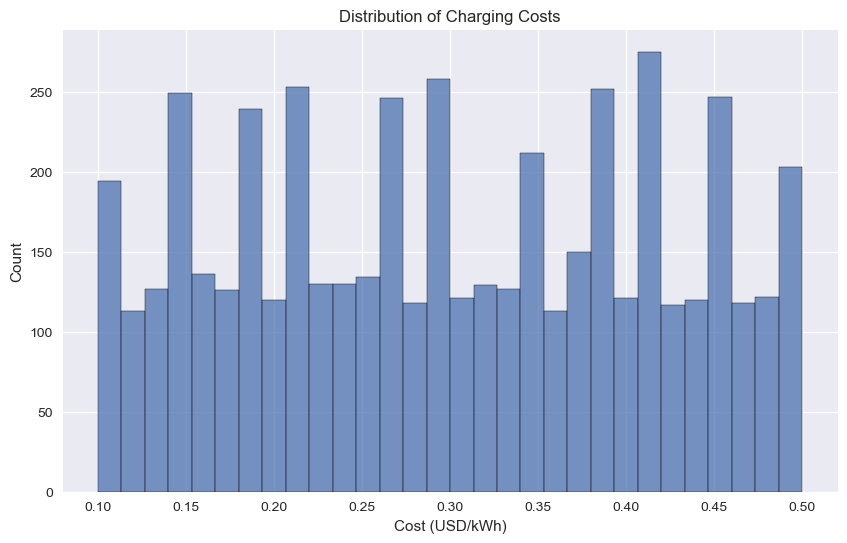

In [46]:
# Distribution of charging costs
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='Cost (USD/kWh)', bins=30)
plt.title('Distribution of Charging Costs')
plt.xlabel('Cost (USD/kWh)')
plt.show()

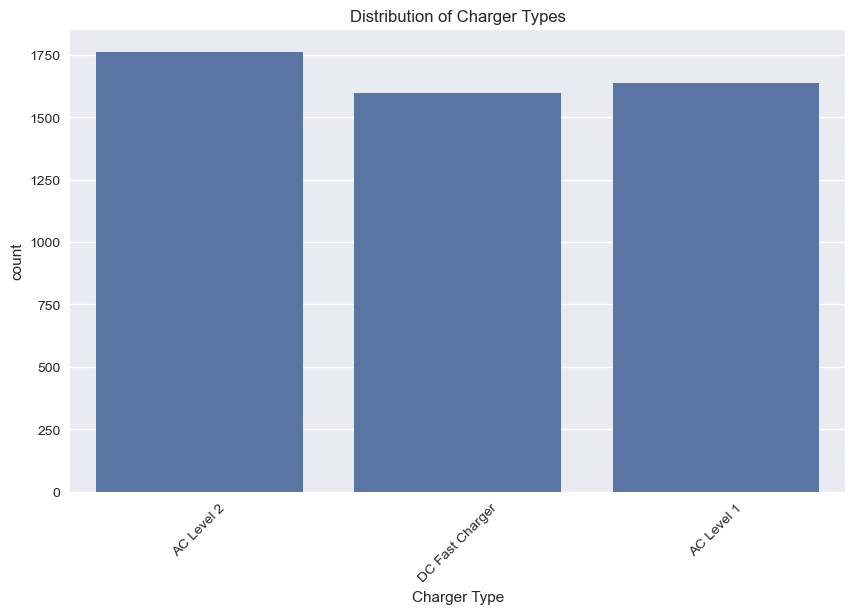

In [50]:
#Distribution of charger types
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Charger Type')
plt.title('Distribution of Charger Types')
plt.xticks(rotation=45)
plt.show()

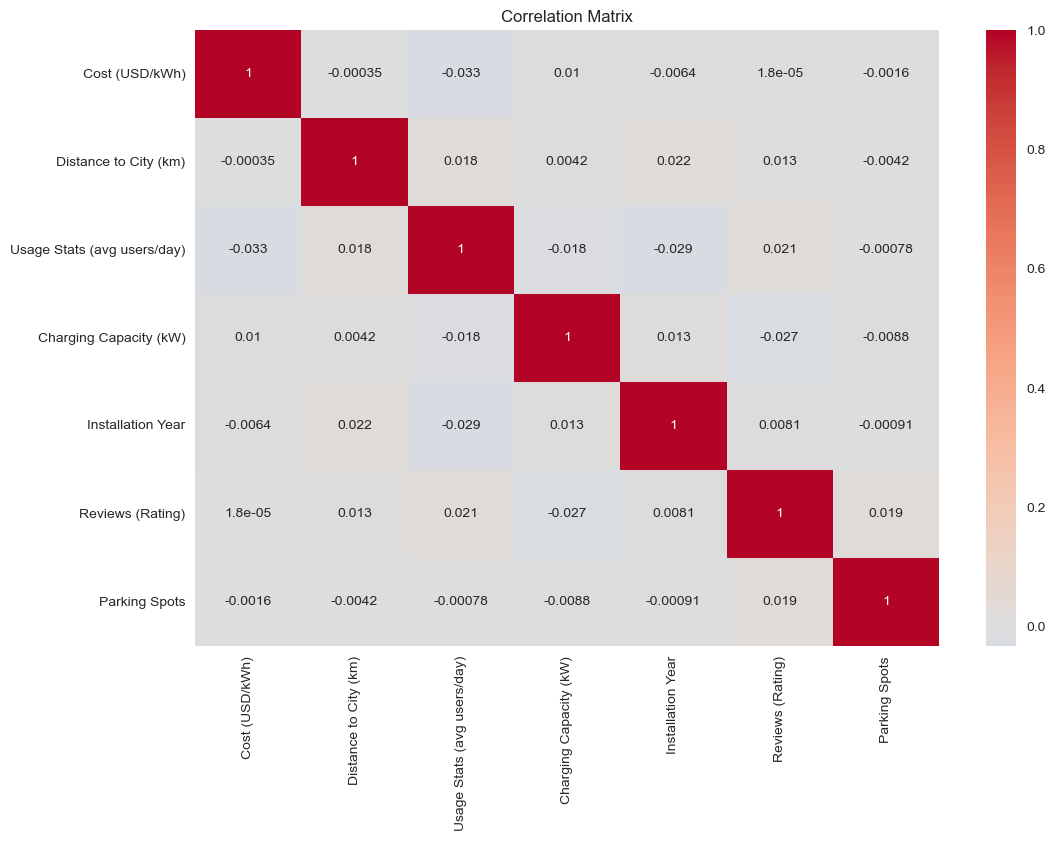

In [54]:
#Correlations matrix for numerical data
numerical_cols = ['Cost (USD/kWh)', 'Distance to City (km)', 'Usage Stats (avg users/day)', 'Charging Capacity (kW)', 'Installation Year', 'Reviews (Rating)', 'Parking Spots']
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

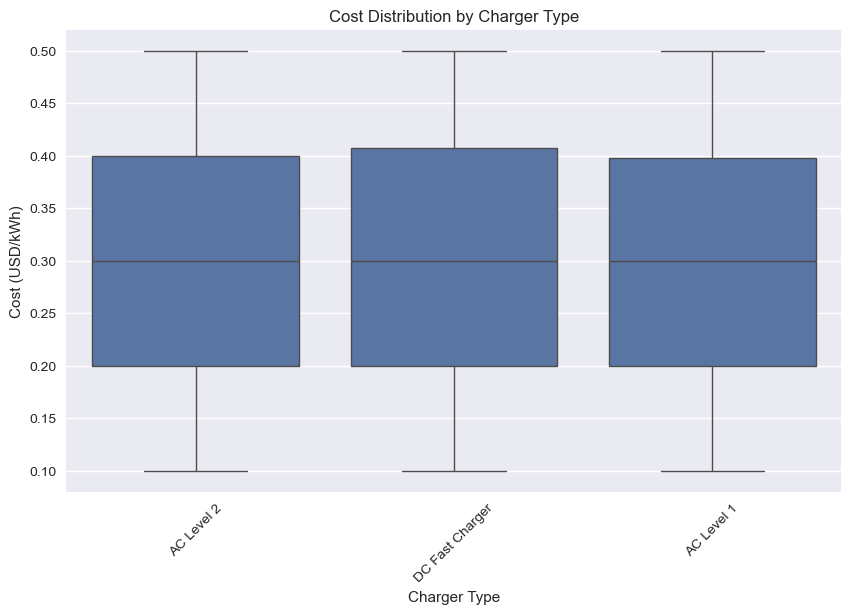

In [56]:
#Box plot for costs by charger type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Charger Type', y='Cost (USD/kWh)')
plt.title('Cost Distribution by Charger Type')
plt.xticks(rotation=45)
plt.show()

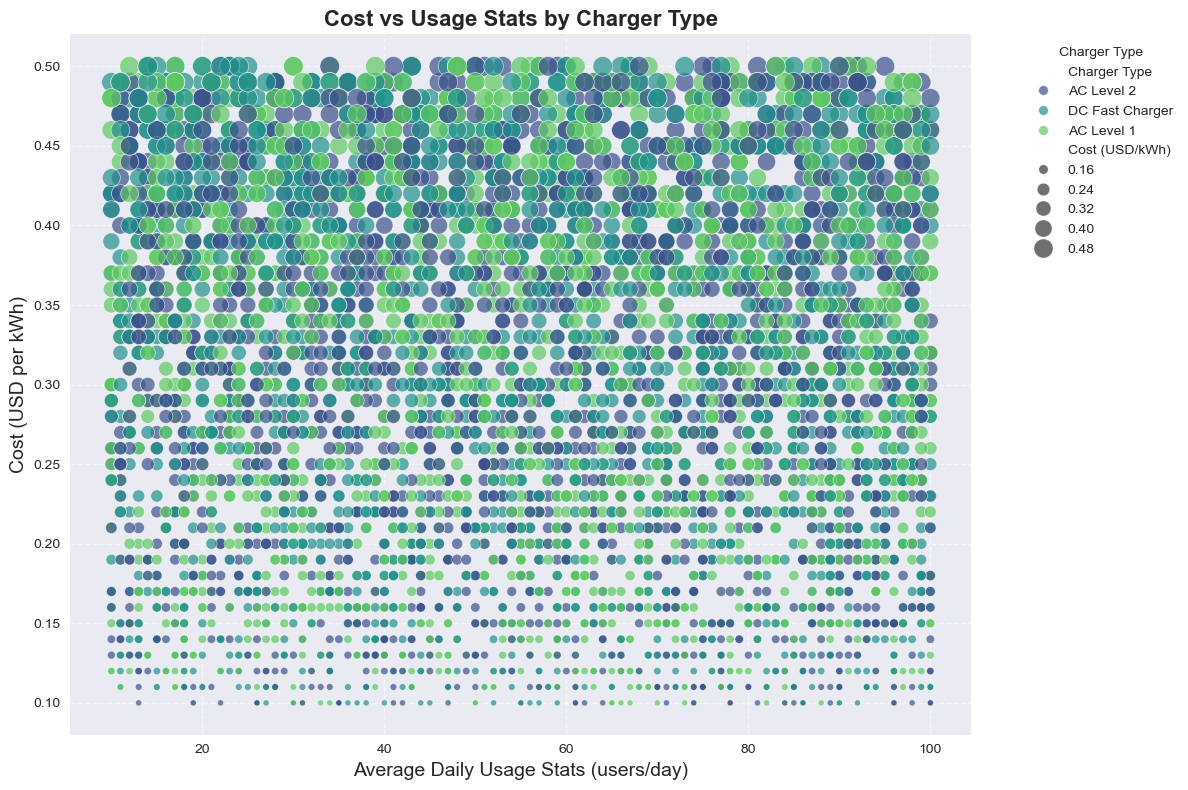

In [64]:
# Scatter plot of cost versus usage with enhancements
plt.figure(figsize=(12, 8))  # Larger figure size for readability
sns.scatterplot(data=df, 
                x='Usage Stats (avg users/day)', 
                y='Cost (USD/kWh)', 
                alpha=0.7,  # Slightly less transparency for clarity
                hue='Charger Type', 
                palette='viridis',  # Use a visually distinct color palette
                size='Cost (USD/kWh)',  # Optional: Size points based on cost
                sizes=(20, 200))  # Define size range for the points

# Add a grid for better readability
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Set title with larger font
plt.title('Cost vs Usage Stats by Charger Type', fontsize=16, fontweight='bold')

# Add axis labels with larger font
plt.xlabel('Average Daily Usage Stats (users/day)', fontsize=14)
plt.ylabel('Cost (USD per kWh)', fontsize=14)

# Add a legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Charger Type', fontsize=10)

# Tight layout to minimize white space
plt.tight_layout()

# Show the plot
plt.show()  

In [66]:
# Summary statistics by station operator 
print("\nSummary by Station Operator:")
operator_summary = df.groupby('Station Operator').agg({
    'Cost (USD/kWh)': ['mean', 'min', 'max', 'count'],
    'Reviews (Rating)': 'mean',
    'Usage Stats (avg users/day)': 'mean'
}).round(2)
print(operator_summary)


Summary by Station Operator:
                 Cost (USD/kWh)                 Reviews (Rating)  \
                           mean  min  max count             mean   
Station Operator                                                   
ChargePoint                 0.3  0.1  0.5  1004             3.98   
EVgo                        0.3  0.1  0.5  1002             4.00   
Greenlots                   0.3  0.1  0.5   987             3.98   
Ionity                      0.3  0.1  0.5   978             3.98   
Tesla                       0.3  0.1  0.5  1029             4.03   

                 Usage Stats (avg users/day)  
                                        mean  
Station Operator                              
ChargePoint                            55.72  
EVgo                                   56.66  
Greenlots                              56.21  
Ionity                                 54.65  
Tesla                                  54.05  


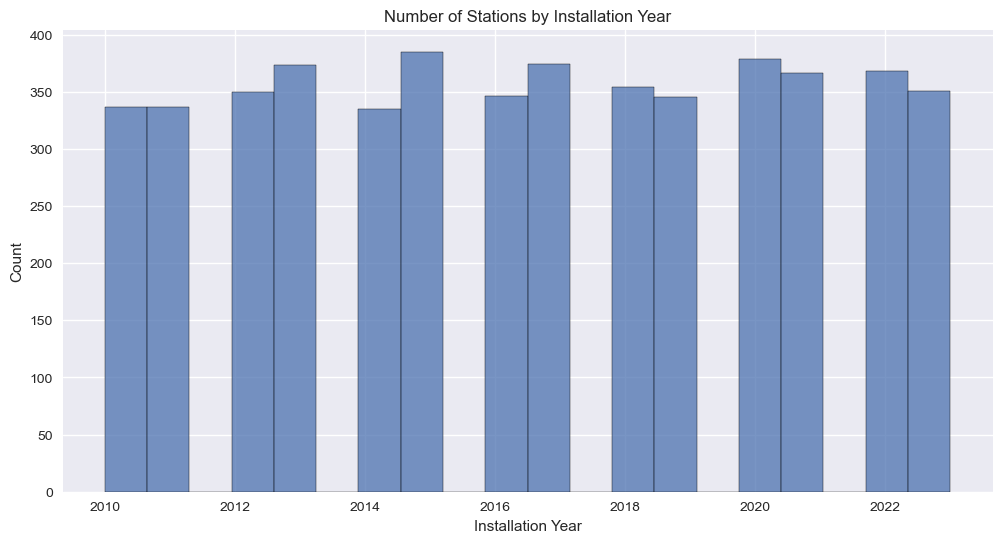

In [68]:
#Installation trends over time
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Installation Year', bins=20)
plt.title('Number of Stations by Installation Year')
plt.show()

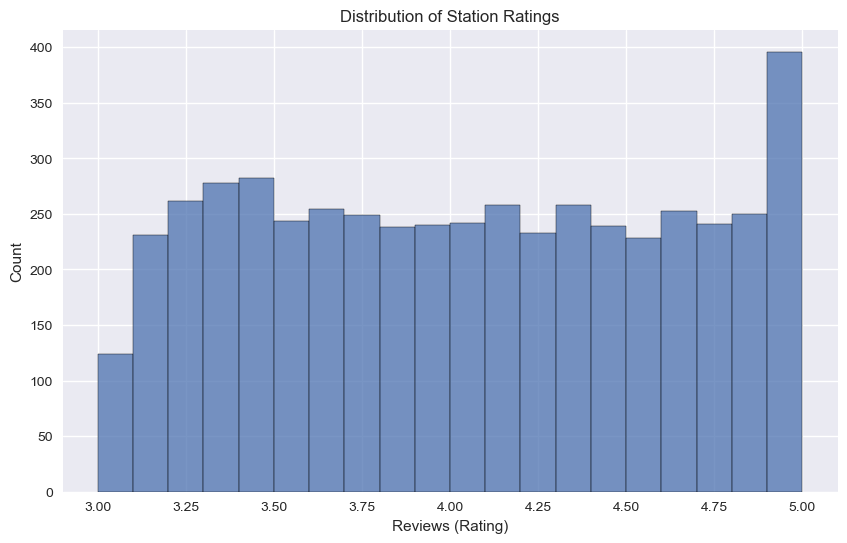

In [70]:
#Average ratings distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Reviews (Rating)', bins=20)
plt.title('Distribution of Station Ratings')
plt.show()